In [1]:
%load_ext autoreload
%autoreload 2
import os

os.environ["LIBRARY_PATH"]="/usr/local/cuda-12.2/lib64/stubs:$LIBRARY_PATH"
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
#model_id = "meta-llama/Meta-Llama-3.1-70B-Instruct"

In [2]:


from src.llm.PredictionUtils import init_model_and_tokenizer, llm_gen


model, tokenizer = init_model_and_tokenizer(model_id,
                                            enable_lora=True,
                                            tensor_parallel_size=1,
                                            )

INFO 09-24 08:34:32 llm_engine.py:223] Initializing an LLM engine (v0.6.1.post2) with config: model='meta-llama/Meta-Llama-3.1-8B-Instruct', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3.1-8B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=2000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=meta-llama/Meta-Llama-3.1-8B-Instruct, use_v2_block_manager=False, num_scheduler_steps=1, ena

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 09-24 08:34:38 model_runner.py:1008] Loading model weights took 14.9927 GB
INFO 09-24 08:34:42 gpu_executor.py:122] # GPU blocks: 27860, # CPU blocks: 2048
INFO 09-24 08:34:43 model_runner.py:1311] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 09-24 08:34:43 model_runner.py:1315] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 09-24 08:35:00 model_runner.py:1430] Graph capturing finished in 17 secs.


In [3]:

from datasets import load_dataset

ds=load_dataset("kanhatakeyama/material-properties",split="train")
ds=ds.shuffle(seed=1)
len(ds)

7241

In [4]:
#train_ds = ds.select(range(24000))
#test_ds = ds.select(range(24000, 24800))
train_ds = ds.select(range(7000))
test_ds = ds.select(range(7000, 7200))

train_ds[0]



{'CompName': 'unknown',
 'SMILES': 'CC1=CC=C(C=C1)O',
 'Property': 'Vapor pressure',
 'Value': 0.11,
 'unit': '[kPa]',
 'Source': 'Wikipedia/Wikidata'}

In [5]:
import random
prompt_list=[]
problems=[]
n_records=8
target_ds=test_ds
n_records=min(n_records,len(target_ds))
for i in range(n_records):
    record=random.choice(target_ds)
    q=f"Predict "+record["Property"]+" "+record["unit"]+" for "+record["CompName"]+" (Compound X) with SMILES "+str(record["SMILES"])+". The prediction consists of #Reason and #Prediction. The #Reason is the quantitative explanation of the prediction. The #Prediction is the predicted value and the unit of the prediction."
    messages=[
        {"role": "user", "content": q},
    ]
    prompt=tokenizer.apply_chat_template(messages,tokenize=False)
    prompt_list.append(prompt+ "assistant\n\n#Reason\n")
    problems.append(record)


In [9]:
import glob
from tqdm import tqdm
from src.prop.utils import parse_Q_R_A_prediction
import torch
lora_model_list=glob.glob("output0919_threshold_0.05_lora_kqvo_proj/checkpoint-*")
lora_model_list=glob.glob("sftlab/output/sftlab-experiments/test/1-llama3_1_8b-zero1/checkpoint-*")
lora_model_list= sorted(lora_model_list, key=lambda x: int(x.split('-')[-1]))
print(len(lora_model_list))

prediction_dict={}

cnt=0
for model_path in tqdm(lora_model_list[:]):
    cnt+=1
    del model
    #cudaを解放
    torch.cuda.empty_cache()

    #フルパラモデルを読み込み
    model, tokenizer = init_model_and_tokenizer(model_path,
                                                enable_lora=False,
                                                tensor_parallel_size=1,
                                                )
    #推論
    predicted_texts=llm_gen(model,prompt_list,
                            #enable_lora=True,
                            #lora_path=lora_model,
                            #lora_id=cnt
                            )
    good_records=parse_Q_R_A_prediction(predicted_texts,problems)
    prediction_dict[model_path]=good_records

6


  0%|          | 0/6 [00:00<?, ?it/s]

INFO 09-24 08:37:55 llm_engine.py:223] Initializing an LLM engine (v0.6.1.post2) with config: model='sftlab/output/sftlab-experiments/test/1-llama3_1_8b-zero1/checkpoint-130', speculative_config=None, tokenizer='sftlab/output/sftlab-experiments/test/1-llama3_1_8b-zero1/checkpoint-130', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=2000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=sftlab/output/sftlab-ex

Processed prompts:   0%|          | 0/16 [01:39<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


INFO 09-24 08:37:56 model_runner.py:997] Starting to load model sftlab/output/sftlab-experiments/test/1-llama3_1_8b-zero1/checkpoint-130...


Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


INFO 09-24 08:38:28 model_runner.py:1008] Loading model weights took 14.9575 GB
INFO 09-24 08:38:28 gpu_executor.py:122] # GPU blocks: 28119, # CPU blocks: 2048
INFO 09-24 08:38:28 model_runner.py:1311] Capturing the model for CUDA graphs. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI.
INFO 09-24 08:38:28 model_runner.py:1315] CUDA graphs can take additional 1~3 GiB memory per GPU. If you are running out of memory, consider decreasing `gpu_memory_utilization` or enforcing eager mode. You can also reduce the `max_num_seqs` as needed to decrease memory usage.
INFO 09-24 08:38:40 model_runner.py:1430] Graph capturing finished in 12 secs.


 17%|█▋        | 1/6 [00:48<04:04, 48.80s/it]

INFO 09-24 08:38:44 llm_engine.py:223] Initializing an LLM engine (v0.6.1.post2) with config: model='sftlab/output/sftlab-experiments/test/1-llama3_1_8b-zero1/checkpoint-260', speculative_config=None, tokenizer='sftlab/output/sftlab-experiments/test/1-llama3_1_8b-zero1/checkpoint-260', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=2000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=sftlab/output/sftlab-ex

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]


 17%|█▋        | 1/6 [01:14<06:11, 74.40s/it]


KeyboardInterrupt: 

In [10]:

#predicted_texts=llm_gen(model,prompt_list,
#                        enable_lora=False,
#                        )
#good_records=parse_Q_R_A_prediction(predicted_texts,problems)
#prediction_dict["original"]=good_records

In [10]:
#import json 
#with open("data/predict/0919prediction_dict_kqvo_proj.json","w") as f:
#    json.dump(prediction_dict,f,indent=2)

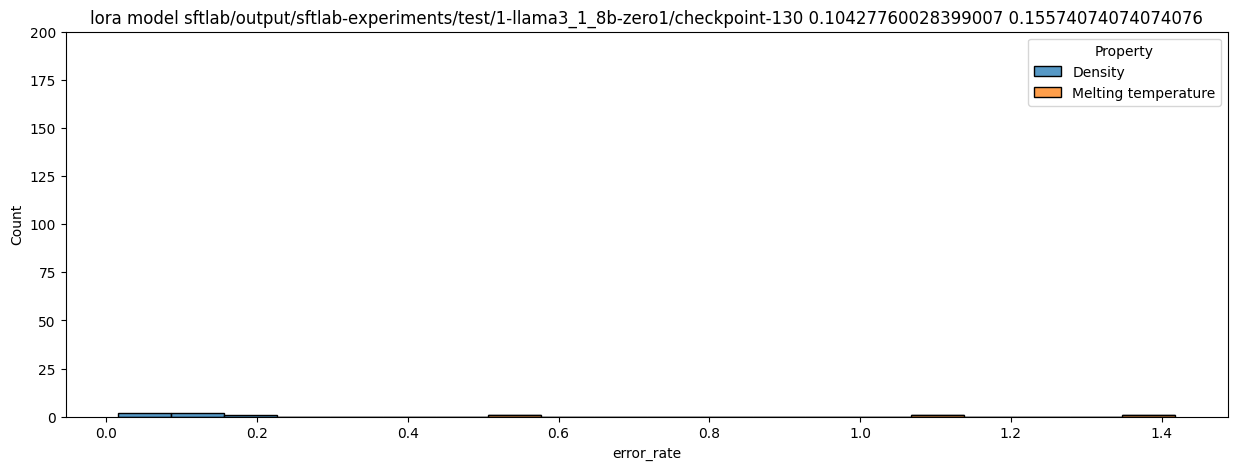

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for lora_name,good_records in prediction_dict.items():

    df=pd.DataFrame(good_records)

    plt.figure(figsize=(15, 5))
    sns.histplot(df[df["error_rate"]<2], x="error_rate", hue="Property", multiple="stack", 
                bins=20)


    s_df=df[df["error_rate"]<1]
    median1=s_df["error_rate"].median()
    median2=df["error_rate"].median()
    plt.title(f"lora model {lora_name} {median1} {median2}")
    plt.ylim(0, 200)